In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import pm4py
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
%run "../ConvertersClass/PatternsConverter.ipynb"
%run "../ConvertersClass/LogConverter.ipynb"

In [12]:
# A custom exception class
class MyException(Exception):
    pass

class ModelLoader():
    def __init__(self, mode, path_patterns_img_dir, paths_patterns_XES_data=None, 
                 caseID_col_name=None, act_col_name=None, ts_col_name=None):
        self.path_patterns_img_dir = path_patterns_img_dir
        if mode == 0:
            self.paths_patterns_XES_data = paths_patterns_XES_data
            
            # Динамические поля (переменные объекта)
            self.caseID_col_name = caseID_col_name 
            self.act_col_name = act_col_name
            self.ts_col_name = ts_col_name
            self.__convert_data_to_img()     
        
    def __convert_data_to_img(self):
        activities = set()
        for path in self.paths_patterns_XES_data:
            log = pm4py.read_xes(path)
            for act in pd.unique(log[self.act_col_name].values.ravel()):
                activities.add(act)
        
        PatternsConverter.set_activities(activities)
        for path in self.paths_patterns_XES_data:
            act_conv = PatternsConverter(path, self.caseID_col_name, self.act_col_name, self.ts_col_name)
            name = os.path.basename(path)
            size = len(name)
            path_to_pattern_dir = self.path_patterns_img_dir + "/" + name[:size-4]
            if not os.path.exists(path_to_pattern_dir):
                os.makedirs(path_to_pattern_dir)
            act_conv.convert(path_to_pattern_dir)
        
       
            
            
    def load_scale_data(self, show_sample):
        self.img_data = tf.keras.utils.image_dataset_from_directory(self.path_patterns_img_dir)
        self.class_names = self.img_data.class_names
        
        if show_sample:
            data_iterator = self.img_data.as_numpy_iterator()
            batch = data_iterator.next()
            fig, ax = plt.subplots(ncols=4, figsize=(20,20))
            for idx, img in enumerate(batch[0][:4]):
                ax[idx].imshow(img.astype(int))
                ax[idx].title.set_text(batch[1][idx])
                
        self.img_data = self.img_data.map(lambda x,y: (x/255, y))
        if show_sample:
            self.img_data.as_numpy_iterator().next()
    
    def split_data(self, train_size_prop, val_size_prop, test_size_prop):
        
        arr = np.array([train_size_prop, val_size_prop, test_size_prop])

        if (arr >= 0).all() and (arr <= 1).all():
            train_size = int(len(self.img_data)*train_size_prop)
            val_size = int(len(self.img_data)*val_size_prop)
            test_size = int(len(self.img_data)*test_size_prop)
            print("Whole data size is " + str(len(self.img_data)) + "\nTraining data size is " + str(train_size))
            
            self.train = self.img_data.take(train_size)
            self.val = self.img_data.skip(train_size).take(val_size)
            self.test = self.img_data.skip(train_size+val_size).take(test_size)
        else:
            raise MyException("Some of the proportions are out of range!")
            
    def __build_model(self):
        self.model = Sequential()
        num_classes = len(self.img_data)

        self.model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
        self.model.add(MaxPooling2D())
        self.model.add(Conv2D(32, (3,3), 1, activation='relu'))
        self.model.add(MaxPooling2D())
        self.model.add(Conv2D(16, (3,3), 1, activation='relu'))
        self.model.add(MaxPooling2D())
        self.model.add(Dropout(0.2))
        self.model.add(Flatten())
        self.model.add(Dense(num_classes, activation='relu'))
        
        self.model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    def __train_model(self, number_epochs, add_data_autotune):
        
        if add_data_autotune:
            AUTOTUNE = tf.data.AUTOTUNE
            self.train = self.train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
            self.val = self.val.cache().prefetch(buffer_size=AUTOTUNE)
            
        logdir='logs'
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
        callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
        
        self.hist = self.model.fit(self.train, epochs = number_epochs, validation_data=self.val, callbacks=[callback, tensorboard_callback])
    
    def plot_model_performance():
        fig = plt.figure()
        plt.plot(self.hist.history['loss'], color='teal', label='loss')
        plt.plot(self.hist.history['val_loss'], color='orange', label='val_loss')
        fig.suptitle('Loss', fontsize=20)
        plt.legend(loc="upper left")
        plt.show()
        
        fig = plt.figure()
        plt.plot(self.hist.history['accuracy'], color='teal', label='accuracy')
        plt.plot(self.hist.history['val_accuracy'], color='orange', label='val_accuracy')
        fig.suptitle('Accuracy', fontsize=20)
        plt.legend(loc="upper left")
        plt.show()
        
    def model_summary(model):
        print(model.summary())
    
    def create_model(self, number_epochs, add_data_autotune):
        self.__build_model()
        self.__train_model(number_epochs, add_data_autotune)
        return self.model
    
    @classmethod
    def save_model(cls, model, path_to_model_dir, model_name):
        model.save(os.path.join(path_to_model_dir, model_name + ".h5"))
        
    @classmethod
    def load_build_model(cls, path_to_model):
        return load_model(path_to_model)

IndentationError: expected an indented block after 'for' statement on line 35 (811772150.py, line 37)

In [4]:
xes_data = ['../data_2/XES_NETS/pattern_between_after_before.xes',
           '../data_2/XES_NETS/pattern_bounded_3_times.xes',
           '../data_2/XES_NETS/pattern_exist_act_uni.xes',
           '../data_2/XES_NETS/pattern_response_direct.xes']

In [ ]:
model_loader = ModelLoader(1, '../data_2/patterns')

model_loader.load_scale_data(True)
model_loader.split_data(0.7, 0.2, 0.1)
model = model_loader.create_model(5, True)
plot_performance(model)

In [7]:
model = ModelLoader.load_build_model("../models/pattern_model_10.h5")

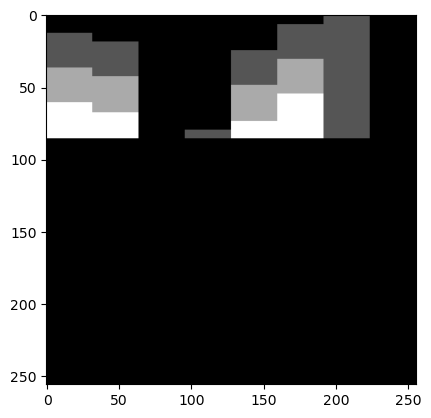

In [9]:
img = cv2.imread('../direct_image_29.png')
plt.imshow(img)
plt.show()

In [10]:
yhat = model.predict(np.expand_dims(img/255, 0))
class_names = tf.keras.utils.image_dataset_from_directory("../data_2/patterns").class_names
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(yhat)])
)

1/1 [==============================] - 0s 411ms/step
Found 3471 files belonging to 4 classes.
This image most likely belongs to pattern_response_direct.


In [11]:
yhat

array([[ 0.      ,  0.      , 12.248109, 22.104836,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.     